# Pandas support

<div class="alert alert-warning">

**Warning:** pandas support is currently experimental, don't expect everything to work.

</div>

It is convenient to use the Pandas package when dealing with numerical data, so Pint provides PintArray. A PintArray is a Pandas Extension Array, which allows Pandas to recognise the Quantity and store it in Pandas DataFrames and Series.

## Installation


Pandas support is provided by the `pint-pandas` package. To install it use either:
```
python -m pip install pint-pandas
```
Or:
```
conda install -c conda-forge pint-pandas
```

## Basic example

This example will show the simplist way to use pandas with pint and the underlying objects. It's slightly fiddly as you are not reading from a file. A more normal use case is given in Reading a csv.

First some imports

In [1]:
import pandas as pd 
import pint
import pint_pandas
pint_pandas.show_versions()

{'numpy': '1.23.3',
 'pandas': '1.5.2',
 'pint': '0.20.2.dev16+g01411c7',
 'pint_pandas': '0.4.dev40+g2f39497.d20221212'}


Next, we create a DataFrame with PintArrays as columns.

In [2]:
df = pd.DataFrame({
    "torque": pd.Series([1., 2., 2., 3.], dtype="pint[lbf ft]"),
    "angular_velocity": pd.Series([1., 2., 2., 3.], dtype="pint[rpm]"),
})
df

,torque,angular_velocity
0,1.0,1.0
1,2.0,2.0
2,2.0,2.0
3,3.0,3.0


Operations with columns are units aware so behave as we would intuitively expect.

In [3]:
df['power'] = df['torque'] * df['angular_velocity']
df

,torque,angular_velocity,power
0,1.0,1.0,1.0
1,2.0,2.0,4.0
2,2.0,2.0,4.0
3,3.0,3.0,9.0


We can see the columns' units in the dtypes attribute

In [4]:
df.dtypes

torque                                       pint[foot * force_pound]
angular_velocity                         pint[revolutions_per_minute]
power               pint[foot * force_pound * revolutions_per_minute]
dtype: object

Each column can be accessed as a Pandas Series

In [5]:
df.power

0    1.0
1    4.0
2    4.0
3    9.0
Name: power, dtype: pint[foot * force_pound * revolutions_per_minute]

Which contains a PintArray

In [6]:
df.power.values

<PintArray>
[1.0, 4.0, 4.0, 9.0]
Length: 4, dtype: pint[foot * force_pound * revolutions_per_minute]

The PintArray contains a Quantity

In [7]:
df.power.values.quantity

Magnitude,[1.0 4.0 4.0 9.0]
Units,foot force_pound revolutions_per_minute


Pandas Series accessors are provided for most Quantity properties and methods, which will convert the result to a Series where possible.

In [8]:
df.power.pint.units

<Unit('foot * force_pound * revolutions_per_minute')>

In [9]:
df.power.pint.to("kW").values

<PintArray>
[0.00014198092353610379,  0.0005679236941444151,  0.0005679236941444151,
   0.001277828311824934]
Length: 4, dtype: pint[kilowatt]

## Reading from csv

Reading from files is the far more standard way to use pandas. To facilitate this, DataFrame accessors are provided to make it easy to get to PintArrays. 

In [10]:
import pandas as pd 
import pint
import pint_pandas
import io

Here's the contents of the csv file.

In [11]:
test_data = '''ShaftSpeedIndex,rpm,1200,1200,1200,1600,1600,1600,2300,2300,2300
pump,,A,B,C,A,B,C,A,B,C
TestDate,No Unit,01/01,01/01,01/01,01/01,01/01,01/01,01/02,01/02,01/02
ShaftSpeed,rpm,1200,1200,1200,1600,1600,1600,2300,2300,2300
FlowRate,m^3 h^-1,8.72,9.28,9.31,11.61,12.78,13.51,18.32,17.90,19.23
DifferentialPressure,kPa,162.03,144.16,136.47,286.86,241.41,204.21,533.17,526.74,440.76
ShaftPower,kW,1.32,1.23,1.18,3.09,2.78,2.50,8.59,8.51,7.61
Efficiency,dimensionless,30.60,31.16,30.70,30.72,31.83,31.81,32.52,31.67,32.05'''

Let's read that into a DataFrame.
Here io.StringIO is used in place of reading a file from disk, whereas a csv file path would typically be used and is shown commented.

In [12]:
df = pd.read_csv(io.StringIO(test_data), header=[0, 1], index_col = [0,1]).T
# convert numeric columns from strings to ints or floats
numeric_cols = df.columns[1:]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)
df

TestDate ShaftSpeed FlowRate DifferentialPressure  \
                      No Unit        rpm m^3 h^-1                  kPa   
ShaftSpeedIndex pump                                                     
1200            A       01/01       1200     8.72               162.03   
                B       01/01       1200     9.28               144.16   
                C       01/01       1200     9.31               136.47   
1600            A       01/01       1600    11.61               286.86   
                B       01/01       1600    12.78               241.41   
                C       01/01       1600    13.51               204.21   
2300            A       01/02       2300    18.32               533.17   
                B       01/02       2300    17.90               526.74   
                C       01/02       2300    19.23               440.76   

                     ShaftPower    Efficiency  
                             kW dimensionless  
ShaftSpeedIndex pump                           
1200            A          1.32         30.60  
                B          1.23         31.16  
                C          1.18         30.70  
1600            A          3.09         30.72  
                B          2.78         31.83  
                C          2.50         31.81  
2300            A          8.59         32.52  
                B          8.51         31.67  
                C          7.61         32.05

In [13]:
df.dtypes

TestDate              No Unit           object
ShaftSpeed            rpm                int64
FlowRate              m^3 h^-1         float64
DifferentialPressure  kPa              float64
ShaftPower            kW               float64
Efficiency            dimensionless    float64
dtype: object

Then use the DataFrame's pint accessor's quantify method to convert the columns from `np.ndarray`s to PintArrays, with units from the bottom column level.

Using 'No Unit' as the unit will prevent quantify converting a column to a PintArray. This can be changed by changing pint_pandas.pint_array.NO_UNIT.

In [14]:
df.dtypes

TestDate              No Unit           object
ShaftSpeed            rpm                int64
FlowRate              m^3 h^-1         float64
DifferentialPressure  kPa              float64
ShaftPower            kW               float64
Efficiency            dimensionless    float64
dtype: object

In [15]:
df_ = df.pint.quantify(level=-1)
df_

TestDate ShaftSpeed FlowRate DifferentialPressure  \
ShaftSpeedIndex pump                                                     
1200            A       01/01       1200     8.72               162.03   
                B       01/01       1200     9.28               144.16   
                C       01/01       1200     9.31               136.47   
1600            A       01/01       1600    11.61               286.86   
                B       01/01       1600    12.78               241.41   
                C       01/01       1600    13.51               204.21   
2300            A       01/02       2300    18.32               533.17   
                B       01/02       2300     17.9               526.74   
                C       01/02       2300    19.23               440.76   

                     ShaftPower Efficiency  
ShaftSpeedIndex pump                        
1200            A          1.32       30.6  
                B          1.23      31.16  
                C          1.18       30.7  
1600            A          3.09      30.72  
                B          2.78      31.83  
                C           2.5      31.81  
2300            A          8.59      32.52  
                B          8.51      31.67  
                C          7.61      32.05

Let's confirm the units have been parsed correctly

In [16]:
df_.dtypes

TestDate                                      object
ShaftSpeed              pint[revolutions_per_minute]
FlowRate                     pint[meter ** 3 / hour]
DifferentialPressure                pint[kilopascal]
ShaftPower                            pint[kilowatt]
Efficiency                       pint[dimensionless]
dtype: object

Here the h in m^3 h^-1 has been parsed as the planck constant. Let's change the unit to hours.

In [17]:
df_['FlowRate'] = pint_pandas.PintArray(df_['FlowRate'].values.quantity.m, dtype = "pint[m^3/hr]")
df_.dtypes

TestDate                                      object
ShaftSpeed              pint[revolutions_per_minute]
FlowRate                     pint[meter ** 3 / hour]
DifferentialPressure                pint[kilopascal]
ShaftPower                            pint[kilowatt]
Efficiency                       pint[dimensionless]
dtype: object

As previously, operations between DataFrame columns are unit aware

In [18]:
df_.ShaftPower / df_.ShaftSpeed

ShaftSpeedIndex  pump
1200             A                      0.0011
                 B                    0.001025
                 C       0.0009833333333333332
1600             A       0.0019312499999999998
                 B                   0.0017375
                 C                   0.0015625
2300             A        0.003734782608695652
                 B       0.0036999999999999997
                 C       0.0033086956521739133
dtype: pint[kilowatt / revolutions_per_minute]

In [19]:
df_['ShaftTorque'] = df_.ShaftPower / df_.ShaftSpeed
df_['FluidPower'] = df_['FlowRate'] * df_['DifferentialPressure']
df_

TestDate ShaftSpeed FlowRate DifferentialPressure  \
ShaftSpeedIndex pump                                                     
1200            A       01/01       1200     8.72               162.03   
                B       01/01       1200     9.28               144.16   
                C       01/01       1200     9.31               136.47   
1600            A       01/01       1600    11.61               286.86   
                B       01/01       1600    12.78               241.41   
                C       01/01       1600    13.51               204.21   
2300            A       01/02       2300    18.32               533.17   
                B       01/02       2300     17.9               526.74   
                C       01/02       2300    19.23               440.76   

                     ShaftPower Efficiency            ShaftTorque  \
ShaftSpeedIndex pump                                                
1200            A          1.32       30.6                 0.0011   
                B          1.23      31.16               0.001025   
                C          1.18       30.7  0.0009833333333333332   
1600            A          3.09      30.72  0.0019312499999999998   
                B          2.78      31.83              0.0017375   
                C           2.5      31.81              0.0015625   
2300            A          8.59      32.52   0.003734782608695652   
                B          8.51      31.67  0.0036999999999999997   
                C          7.61      32.05  0.0033086956521739133   

                              FluidPower  
ShaftSpeedIndex pump                      
1200            A     1412.9016000000001  
                B              1337.8048  
                C     1270.5357000000001  
1600            A              3330.4446  
                B              3085.2198  
                C              2758.8771  
2300            A              9767.6744  
                B      9428.645999999999  
                C              8475.8148

The DataFrame's `pint.dequantify` method then allows us to retrieve the units information as a header row once again.

In [20]:
df_.pint.dequantify()

TestDate             ShaftSpeed          FlowRate  \
unit                  No Unit revolutions_per_minute meter ** 3 / hour   
ShaftSpeedIndex pump                                                     
1200            A       01/01                   1200              8.72   
                B       01/01                   1200              9.28   
                C       01/01                   1200              9.31   
1600            A       01/01                   1600             11.61   
                B       01/01                   1600             12.78   
                C       01/01                   1600             13.51   
2300            A       01/02                   2300             18.32   
                B       01/02                   2300              17.9   
                C       01/02                   2300             19.23   

                     DifferentialPressure ShaftPower    Efficiency  \
unit                           kilopascal   kilowatt dimensionless   
ShaftSpeedIndex pump                                                 
1200            A                  162.03       1.32          30.6   
                B                  144.16       1.23         31.16   
                C                  136.47       1.18          30.7   
1600            A                  286.86       3.09         30.72   
                B                  241.41       2.78         31.83   
                C                  204.21        2.5         31.81   
2300            A                  533.17       8.59         32.52   
                B                  526.74       8.51         31.67   
                C                  440.76       7.61         32.05   

                                           ShaftTorque  \
unit                 kilowatt / revolutions_per_minute   
ShaftSpeedIndex pump                                     
1200            A                               0.0011   
                B                             0.001025   
                C                             0.000983   
1600            A                             0.001931   
                B                             0.001737   
                C                             0.001563   
2300            A                             0.003735   
                B                               0.0037   
                C                             0.003309   

                                         FluidPower  
unit                 kilopascal * meter ** 3 / hour  
ShaftSpeedIndex pump                                 
1200            A                         1412.9016  
                B                         1337.8048  
                C                         1270.5357  
1600            A                         3330.4446  
                B                         3085.2198  
                C                         2758.8771  
2300            A                         9767.6744  
                B                          9428.646  
                C                         8475.8148

This allows for some rather powerful abilities. For example, to change a column's units

In [21]:
df_['FluidPower'] = df_['FluidPower'].pint.to("kW")
df_['FlowRate'] = df_['FlowRate'].pint.to("L/s")
df_['ShaftTorque'] = df_['ShaftTorque'].pint.to("N m")
df_.pint.dequantify()

TestDate             ShaftSpeed       FlowRate  \
unit                  No Unit revolutions_per_minute liter / second   
ShaftSpeedIndex pump                                                  
1200            A       01/01                   1200       2.422222   
                B       01/01                   1200       2.577778   
                C       01/01                   1200       2.586111   
1600            A       01/01                   1600          3.225   
                B       01/01                   1600           3.55   
                C       01/01                   1600       3.752778   
2300            A       01/02                   2300       5.088889   
                B       01/02                   2300       4.972222   
                C       01/02                   2300       5.341667   

                     DifferentialPressure ShaftPower    Efficiency  \
unit                           kilopascal   kilowatt dimensionless   
ShaftSpeedIndex pump                                                 
1200            A                  162.03       1.32          30.6   
                B                  144.16       1.23         31.16   
                C                  136.47       1.18          30.7   
1600            A                  286.86       3.09         30.72   
                B                  241.41       2.78         31.83   
                C                  204.21        2.5         31.81   
2300            A                  533.17       8.59         32.52   
                B                  526.74       8.51         31.67   
                C                  440.76       7.61         32.05   

                        ShaftTorque FluidPower  
unit                 meter * newton   kilowatt  
ShaftSpeedIndex pump                            
1200            A         10.504226   0.392473  
                B          9.788029   0.371612  
                C          9.390142   0.352927  
1600            A         18.442079   0.925123  
                B         16.591903   0.857005  
                C         14.920776   0.766355  
2300            A         35.664547   2.713243  
                B         35.332397   2.619068  
                C         31.595716   2.354393

The units are harder to read than they need be, so lets change pints default format for displaying units.

In [22]:
pint_pandas.PintType.ureg.default_format = "P~"
df_.pint.dequantify()

TestDate ShaftSpeed  FlowRate DifferentialPressure  \
unit                  No Unit        rpm       l/s                  kPa   
ShaftSpeedIndex pump                                                      
1200            A       01/01       1200  2.422222               162.03   
                B       01/01       1200  2.577778               144.16   
                C       01/01       1200  2.586111               136.47   
1600            A       01/01       1600     3.225               286.86   
                B       01/01       1600      3.55               241.41   
                C       01/01       1600  3.752778               204.21   
2300            A       01/02       2300  5.088889               533.17   
                B       01/02       2300  4.972222               526.74   
                C       01/02       2300  5.341667               440.76   

                     ShaftPower Efficiency ShaftTorque FluidPower  
unit                         kW                    N·m         kW  
ShaftSpeedIndex pump                                               
1200            A          1.32       30.6   10.504226   0.392473  
                B          1.23      31.16    9.788029   0.371612  
                C          1.18       30.7    9.390142   0.352927  
1600            A          3.09      30.72   18.442079   0.925123  
                B          2.78      31.83   16.591903   0.857005  
                C           2.5      31.81   14.920776   0.766355  
2300            A          8.59      32.52   35.664547   2.713243  
                B          8.51      31.67   35.332397   2.619068  
                C          7.61      32.05   31.595716   2.354393

or the entire table's units

In [23]:
df_.pint.to_base_units().pint.dequantify()

TestDate  ShaftSpeed  FlowRate DifferentialPressure  \
unit                  No Unit       rad/s      m³/s              kg/m/s²   
ShaftSpeedIndex pump                                                       
1200            A       01/01  125.663706  0.002422             162030.0   
                B       01/01  125.663706  0.002578             144160.0   
                C       01/01  125.663706  0.002586             136470.0   
1600            A       01/01  167.551608  0.003225             286860.0   
                B       01/01  167.551608   0.00355             241410.0   
                C       01/01  167.551608  0.003753             204210.0   
2300            A       01/02  240.855437  0.005089             533170.0   
                B       01/02  240.855437  0.004972             526740.0   
                C       01/02  240.855437  0.005342             440760.0   

                     ShaftPower Efficiency ShaftTorque   FluidPower  
unit                   kg·m²/s³               kg·m²/s²     kg·m²/s³  
ShaftSpeedIndex pump                                                 
1200            A        1320.0       30.6   10.504226   392.472667  
                B        1230.0      31.16    9.788029   371.612444  
                C        1180.0       30.7    9.390142   352.926583  
1600            A        3090.0      30.72   18.442079     925.1235  
                B        2780.0      31.83   16.591903     857.0055  
                C        2500.0      31.81   14.920776    766.35475  
2300            A        8590.0      32.52   35.664547  2713.242889  
                B        8510.0      31.67   35.332397  2619.068333  
                C        7610.0      32.05   31.595716     2354.393

## Plotting
Pint's matplotlib support allows columns with the same dimensionality to be plotted.

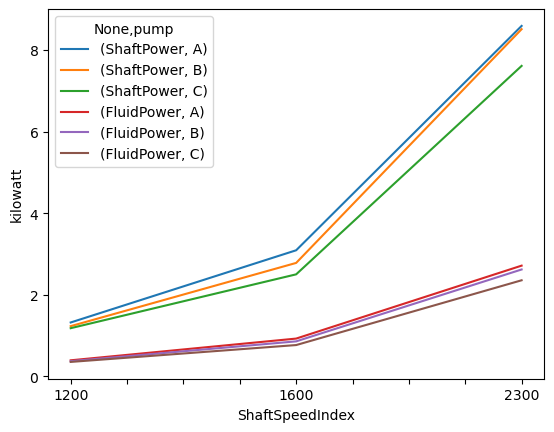

In [24]:
pint_pandas.PintType.ureg.setup_matplotlib()
ax = df_[['ShaftPower', 'FluidPower']].unstack("pump").plot()

In [25]:
ax.yaxis.units

<Unit('kilowatt')>

Note that indexes cannot store PintArrays, so don't contain unit information

In [26]:
print(ax.xaxis.units)

None


## Advanced example
This example shows alternative ways to use pint with pandas and other features.

Start with the same imports.

In [27]:
import pandas as pd 
import pint
import pint_pandas

We'll be use a shorthand for PintArray

In [28]:
PA_ = pint_pandas.PintArray

And set up a unit registry and quantity shorthand.

In [29]:
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity

Operations between PintArrays of different unit registry will not work. We can change the unit registry that will be used in creating new PintArrays to prevent this issue.

In [30]:
pint_pandas.PintType.ureg = ureg

These are the possible ways to create a PintArray.

Note that pint[unit] must be used for the Series constuctor, whereas the PintArray constructor allows the unit string or object.

In [31]:
df = pd.DataFrame({
        "length" : pd.Series([1.,2.], dtype="pint[m]"),
        "width" : PA_([2.,3.], dtype="pint[m]"),
        "distance" : PA_([2.,3.], dtype="m"),
        "height" : PA_([2.,3.], dtype=ureg.m),
        "depth" : PA_.from_1darray_quantity(Q_([2,3],ureg.m)),
        "displacement" : PA_(Q_([2.,3.],ureg.m)),
    })
df

,length,width,distance,height,depth,displacement
0,1.0,2.0,2.0,2.0,2,2.0
1,2.0,3.0,3.0,3.0,3,3.0


In [32]:
df.length.values.units

<Unit('meter')>

Some operations don't return PintArrays. When this happens, the unit will be displayed in the DataFrame's cells, and the column show object dtype.

In [33]:
df['cumulative_length'] = df['length'].cumsum()
df

,length,width,distance,height,depth,displacement,cumulative_length
0,1.0,2.0,2.0,2.0,2,2.0,1.0 meter
1,2.0,3.0,3.0,3.0,3,3.0,3.0 meter


In [34]:
df.dtypes

length               pint[meter]
width                pint[meter]
distance             pint[meter]
height               pint[meter]
depth                pint[meter]
displacement         pint[meter]
cumulative_length         object
dtype: object

To fix this column, use the DataFrame.pint.convert_object_dtype() function.

In [35]:
df = df.pint.convert_object_dtype()
df

,length,width,distance,height,depth,displacement,cumulative_length
0,1.0,2.0,2.0,2.0,2,2.0,1.0
1,2.0,3.0,3.0,3.0,3,3.0,3.0


In [36]:
df.dtypes

length               pint[meter]
width                pint[meter]
distance             pint[meter]
height               pint[meter]
depth                pint[meter]
displacement         pint[meter]
cumulative_length    pint[meter]
dtype: object